In [1]:
# !pip install git+https://github.com/jkirkby3/pymle.git

In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
from typing import Literal, Optional, List, Dict

In [3]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [4]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

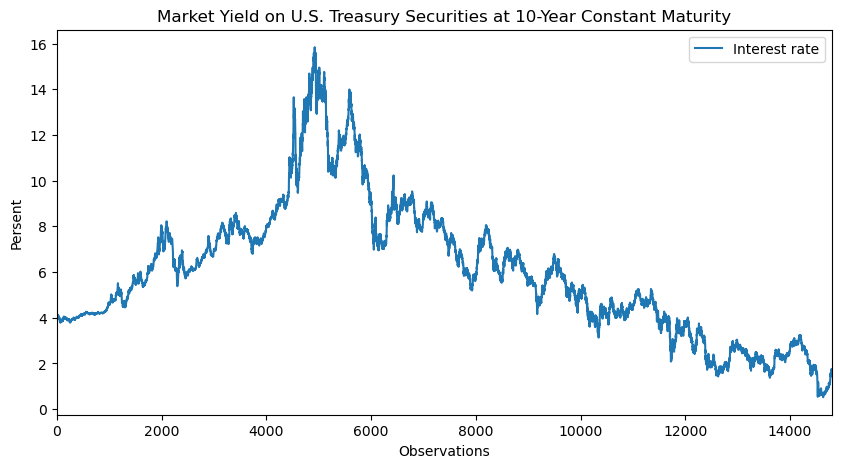

In [5]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

<Axes: xlabel='DATE'>

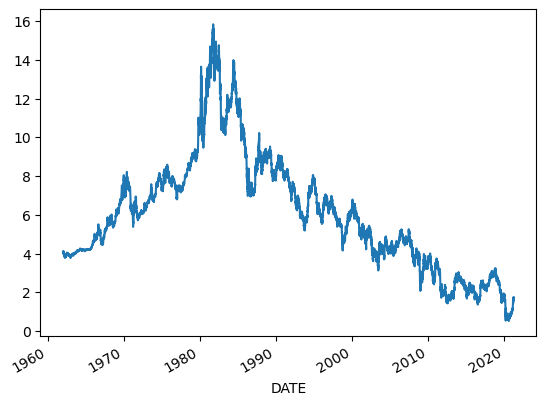

In [6]:
df_IR.index = pd.to_datetime(df_IR['DATE'])
df_IR['DGS10'] = df_IR['DGS10'].astype(float)
df_IR['DGS10'].plot()

In [7]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [8]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -93923.6315674815


c:\Anaconda\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 147, CG iterations: 63, optimality: 2.28e-02, constraint violation: 0.00e+00, execution time: 0.24 s.
Final Params: [0.01259342 1.03329778]
Final Likelihood: 19434.017967984953
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -854523.4307799716
`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 415, CG iterations: 277, optimality: 2.46e+01, constraint violation: 0.00e+00, execution time:  2.3 s.
Final Params: [0.0292836  0.28374461 0.56758146 0.32837493]
Final Likelihood: 20274.18170343365
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 5265.78931838382
`xtol` termination condition is satisfied.
Number of iterations: 93, function evaluations: 452, CG iterations: 171, optimality: 1.61e+01, constraint violation: 0.00e+00, execution time: 0.83 s.
Final Params: [0.01824666 0.02712688 0.43178741]
Final Likelihood: 20050.372296908376
Initial Para

In [9]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -38864.036 - BrownianMotion model with params [0.01259342 1.03329778],
       -40540.363 - CEV model with params [0.0292836  0.28374461 0.56758146 0.32837493],
       -40094.745 - CIR model with params [0.01824666 0.02712688 0.43178741],
       -33258.223 - GeometricBM model with params [0.02229677 0.23203461],
       -33295.215 - IGBM model with params [0.23442787 4.72985863 0.22947909],
       -38862.649 - OrnsteinUhlenbeck model with params [0.01679988 0.37896678 1.03327548],
       -40540.517 - CKLS model with params [0.06225371 0.0100878  0.56478879 0.33182015],
       
The best model is CKLS     with param [0.06225371 0.0100878  0.56478879 0.33182015]


In [10]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -93923.63156681013


`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 75, CG iterations: 46, optimality: 6.05e-07, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.01005816 1.03329725]
Final Likelihood: 19434.025293805942
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -854528.483068367
`xtol` termination condition is satisfied.
Number of iterations: 76, function evaluations: 415, CG iterations: 239, optimality: 2.04e-03, constraint violation: 0.00e+00, execution time: 0.86 s.
Final Params: [0.01190199 0.13421308 0.55881256 0.33762954]
Final Likelihood: 20275.1373235714
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 5258.273685758917
`xtol` termination condition is satisfied.
Number of iterations: 88, function evaluations: 344, CG iterations: 152, optimality: 1.19e-03, constraint violation: 0.00e+00, execution time: 0.58 s.
Final Params: [0.01075957 0.08027616 0.43176874]
Final Likelihood: 20050.14054619275
Initial Params:

In [11]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -38864.051 - BrownianMotion model with params [0.01005816 1.03329725],
       -40542.275 - CEV model with params [0.01190199 0.13421308 0.55881256 0.33762954],
       -40094.281 - CIR model with params [0.01075957 0.08027616 0.43176874],
       -33266.575 - GeometricBM model with params [0.01697631 0.23228466],
       -33283.762 - IGBM model with params [0.20233176 3.82241004 0.23110815],
       -38862.651 - OrnsteinUhlenbeck model with params [0.01644952 0.3898007  1.03330218],
       -40541.409 - CKLS model with params [0.01001518 0.01000061 0.55874105 0.33769824],
       
The best model is CEV     with param [0.01190199 0.13421308 0.55881256 0.33762954]


In [12]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -93923.63156681013
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 132, CG iterations: 57, optimality: 7.87e-05, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.0100114  1.03329725]
Final Likelihood: 19434.025425591346
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -854523.0368307387
`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 675, CG iterations: 370, optimality: 4.35e-05, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.05000138 5.26214708 0.55864565 0.33777235]
Final Likelihood: 20275.7128380015
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 5259.272834164294
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 216, CG iterations: 121, optimality: 9.63e-05, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.04983467 5.08

In [13]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -38864.051 - BrownianMotion model with params [0.0100114  1.03329725],
       -40543.426 - CEV model with params [0.05000138 5.26214708 0.55864565 0.33777235],
       -40095.613 - CIR model with params [0.04983467 5.08186031 0.4317401 ],
       -33266.575 - GeometricBM model with params [0.01679434 0.23229248],
       -33285.793 - IGBM model with params [0.16175506 4.84405842 0.23099952],
       -38863.217 - OrnsteinUhlenbeck model with params [0.04600522 5.11106315 1.03325655],
       -40541.409 - CKLS model with params [0.01000172 0.0100002  0.55875214 0.33769825],
       
The best model is CEV     with param [0.05000138 5.26214708 0.55864565 0.33777235]


In [14]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.0292836  0.28374461 0.56758146 0.32837493],
     [0.01190199 0.13421308 0.55881256 0.33762954],
     [0.05000138 5.26214708 0.55864565 0.33777235]


In [15]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [16]:

model_details = {
    "Kessler": {"density": KesslerDensity, "params": {}},
    "Shoji-Ozaki": {"density": ShojiOzakiDensity, "params": {}},
    "Euler": {"density": EulerDensity, "params": {}}
}


models = {
    "BrownianMotion": {"class": BrownianMotion(), "bounds": [(0.01, 10), (0.01, 2)], "guess": [0.01, 0.2]},
    "CEV": {"class": CEV(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.01, 0.2]},
    "CIR": {"class": CIR(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.2]},
    "GeometricBM": {"class": GeometricBM(), "bounds": [(0.01, 10), (0.01, 2)], "guess": [0.01, 0.2]},
    "IGBM": {"class": IGBM(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.2]},
    "OrnsteinUhlenbeck": {"class": OrnsteinUhlenbeck(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.2]},
    "CKLS": {"class": CKLS(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.01, 0.2]}
}

dt = 1 / 252


for method, details in model_details.items():
    density_func = details["density"]
    params_estimates = []
    
    for model_name, model_info in models.items():
        bounds = model_info["bounds"]
        initial_guess = model_info["guess"]
        model_instance = model_info["class"]
        
        estimator = AnalyticalMLE(sample, bounds, dt, density=density_func(model_instance))
        estimated_params = estimator.estimate_params(initial_guess)
        aic_value = estimated_params.aic
        details["params"][model_name] = {
            "params": estimated_params.params,
            "aic": aic_value
        }
        
        print(f"AIC for {method} estimation ({model_name}): {aic_value} with params {estimated_params.params}")
        
    best_model = min(details["params"].items(), key=lambda item: item[1]["aic"])
    print(f"Best model for {method} method: {best_model[0]} with AIC {best_model[1]['aic']} and params {best_model[1]['params']}\n")

Initial Params: [0.01, 0.2]
Initial Likelihood: -93923.6315674815


`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 147, CG iterations: 63, optimality: 2.28e-02, constraint violation: 0.00e+00, execution time: 0.62 s.
Final Params: [0.01259342 1.03329778]
Final Likelihood: 19434.017967984953
AIC for Kessler estimation (BrownianMotion): -38864.03593596991 with params [0.01259342 1.03329778]
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -854523.4307799716
`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 415, CG iterations: 277, optimality: 2.46e+01, constraint violation: 0.00e+00, execution time:  2.6 s.
Final Params: [0.0292836  0.28374461 0.56758146 0.32837493]
Final Likelihood: 20274.18170343365
AIC for Kessler estimation (CEV): -40540.3634068673 with params [0.0292836  0.28374461 0.56758146 0.32837493]
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 5265.78931838382
`xtol` termination condition is satisfied.
Number of iterations: 93, function eval

In [17]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [18]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

C:\Users\1\AppData\Local\Temp\ipykernel_16336\1721718896.py:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


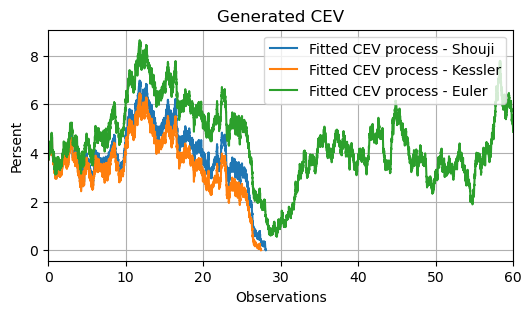

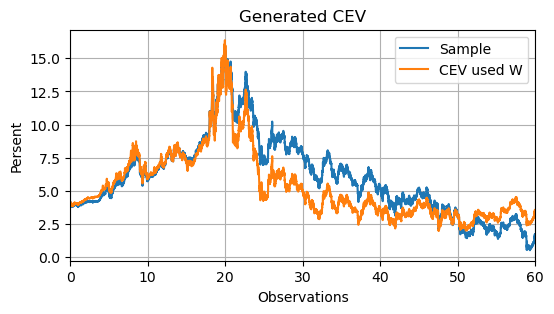

In [19]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

C:\Users\1\AppData\Local\Temp\ipykernel_16336\707344539.py:2: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


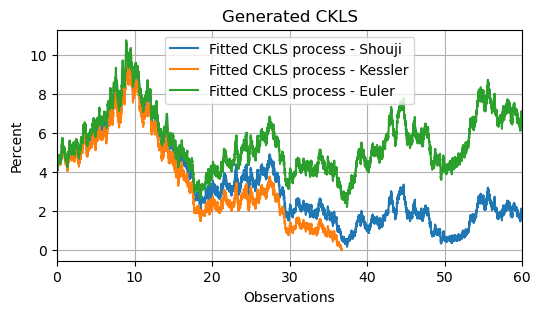

In [20]:
def CKLS_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS


kappa, mu, sigma, gamma = kessler_p


time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)


ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0


for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + CKLS_pr(ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + CKLS_pr(ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + CKLS_pr(ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)


fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label="Fitted CKLS process - Shouji")
plt.plot(time_line, ckls_k, label="Fitted CKLS process - Kessler")
plt.plot(time_line, ckls_e, label="Fitted CKLS process - Euler")
plt.title("Generated CKLS")
plt.ylabel('Percent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [21]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -93923.63156681013
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 132, CG iterations: 57, optimality: 7.87e-05, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.0100114  1.03329725]
Final Likelihood: 19434.025425591346
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -854523.0368307387
`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 675, CG iterations: 370, optimality: 4.35e-05, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.05000138 5.26214708 0.55864565 0.33777235]
Final Likelihood: 20275.7128380015
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 5259.272834164294
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 216, CG iterations: 121, optimality: 9.63e-05, constraint violation: 0.00e+00, execution time: 0.33 s.
Final Params: [0.04983467 5.08

c:\Anaconda\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.28 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -854528.4734238789
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 430, CG iterations: 243, optimality: 1.75e-03, constraint violation: 0.00e+00, execution time: 0.88 s.
Final Params: [0.05876657 5.4471095  0.55841297 0.33799448]
Final Likelihood: 20275.99076708594
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 5258.276833652124
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 272, CG iterations: 133, optimality: 1.20e-02, constraint violation: 0.00e+00, execution time: 0.42 s.
Final Params: [0.07127804 5.32126514 0.43170122]
Final Likelihood: 20051.64221445503
Initial Params: [0.01, 0.2]
Ini

100%|██████████| 1/1 [00:20<00:00, 20.71s/it]

`xtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 365, CG iterations: 177, optimality: 1.10e-04, constraint violation: 0.00e+00, execution time: 0.66 s.
Final Params: [0.01000172 0.0100002  0.55875214 0.33769825]
Final Likelihood: 20274.704369794417


Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [22]:
# Число наблюдений в выборке
n = len(sample)

# Инициализация пустого DataFrame для хранения всех результатов
results_df = pd.DataFrame(columns=["Method", "Model", "Params", "AIC", "BIC"])

# Функция для расчета BIC через AIC, если log_likelihood недоступен
def calculate_bic_from_aic(aic_value, n, num_params):
    log_likelihood = -0.5 * aic_value
    return num_params * np.log(n) - 2 * log_likelihood

# Итерация по каждому методу и каждой модели
for method, details in model_details.items():
    density_func = details["density"]
    
    for model_name, model_info in models.items():
        bounds = model_info["bounds"]
        initial_guess = model_info["guess"]
        model_instance = model_info["class"]
        
        # Оценка параметров и получение AIC для текущей модели и метода
        estimator = AnalyticalMLE(sample, bounds, dt, density=density_func(model_instance))
        estimated_params = estimator.estimate_params(initial_guess)
        
        # Извлекаем AIC и рассчитываем BIC на его основе
        aic_value = estimated_params.aic
        num_params = len(estimated_params.params)
        bic_value = calculate_bic_from_aic(aic_value, n, num_params)
        
        # Создание строки результата в виде DataFrame
        result_row = pd.DataFrame({
            "Method": [method],
            "Model": [model_name],
            "Params": [estimated_params.params],
            "AIC": [aic_value],
            "BIC": [bic_value]
        })
        
        # Объединение текущего результата с основным DataFrame
        results_df = pd.concat([results_df, result_row], ignore_index=True)

# Отображение таблицы результатов
# import ace_tools as tools; tools.display_dataframe_to_user(name="Comprehensive Model Comparison", dataframe=results_df)
results_df

Initial Params: [0.01, 0.2]
Initial Likelihood: -93923.6315674815


c:\Anaconda\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\1\AppData\Local\Temp\ipykernel_16336\4273762289.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)


`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 147, CG iterations: 63, optimality: 2.28e-02, constraint violation: 0.00e+00, execution time: 0.35 s.
Final Params: [0.01259342 1.03329778]
Final Likelihood: 19434.017967984953
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -854523.4307799716
`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 415, CG iterations: 277, optimality: 2.46e+01, constraint violation: 0.00e+00, execution time:  2.3 s.
Final Params: [0.0292836  0.28374461 0.56758146 0.32837493]
Final Likelihood: 20274.18170343365
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 5265.78931838382
`xtol` termination condition is satisfied.
Number of iterations: 93, function evaluations: 452, CG iterations: 171, optimality: 1.61e+01, constraint violation: 0.00e+00, execution time:  0.7 s.
Final Params: [0.01824666 0.02712688 0.43178741]
Final Likelihood: 20050.372296908376
Initial Para

,Method,Model,Params,AIC,BIC
0,Kessler,BrownianMotion,"[0.012593417266232669, 1.0332977774345649]",-38864.035936,-38844.830901
1,Kessler,CEV,"[0.029283604830959136, 0.28374460707669824, 0....",-40540.363407,-40501.953337
2,Kessler,CIR,"[0.018246659820622, 0.027126884964375212, 0.43...",-40094.744594,-40065.937041
3,Kessler,GeometricBM,"[0.0222967661037213, 0.23203461273439624]",-33258.223166,-33239.018131
4,Kessler,IGBM,"[0.2344278719712482, 4.729858629542394, 0.2294...",-33295.214852,-33266.407299
5,Kessler,OrnsteinUhlenbeck,"[0.01679987642389774, 0.37896678142430834, 1.0...",-38862.648620,-38833.841067
6,Kessler,CKLS,"[0.062253708744746346, 0.010087798277913045, 0...",-40540.516708,-40502.106638
7,Shoji-Ozaki,BrownianMotion,"[0.010058157035644527, 1.0332972529801312]",-38864.050588,-38844.845552
8,Shoji-Ozaki,CEV,"[0.011901987851138555, 0.13421308063152038, 0....",-40542.274647,-40503.864577
9,Shoji-Ozaki,CIR,"[0.010759570165864242, 0.08027615570512929, 0....",-40094.281092,-40065.473540


In [23]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [24]:
# Run estimator with parallel calculating:
# K = 100
# i_range   = [i for i in range(1)]
# pool_obj = multiprocessing.Pool()
# answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

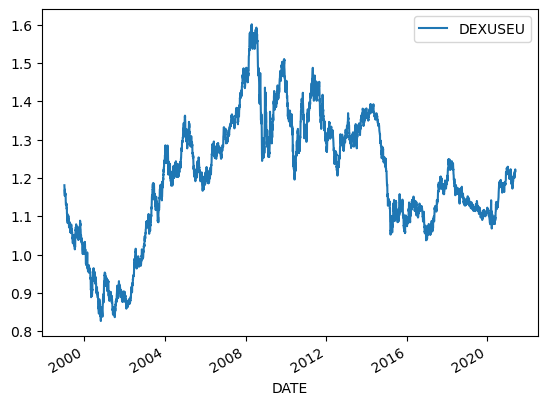

In [25]:
dexuseu = pd.read_csv('DEXUSEU.csv')
dexuseu.index = pd.to_datetime(dexuseu['DATE'])
dexuseu.drop(columns=['DATE'])
dexuseu = dexuseu[dexuseu['DEXUSEU'] != '.']
dexuseu['DEXUSEU'] = dexuseu['DEXUSEU'].astype('Float64')
dexuseu.plot()
plt.show()

In [29]:
from numba import njit
from scipy.stats import ncx2

class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return np.ones(self.Nx) * 2
    
class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta, mu, sigma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)
    
class CEVprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [kappa, mu, sigma, gamma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        # Дрейфовая функция b(x, t)
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        # Диффузионная функция sigma(x, t)
        return params[2] * np.maximum(x, 0)**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        # Производная дрейфовой функции по x
        return -params[0]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        # Производная диффузионной функции по x
        return params[2] * params[3] * np.maximum(x, 0)**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        # Вторая производная диффузионной функции по x
        return params[2] * params[3] * (params[3] - 1) * np.maximum(x, 0)**(params[3] - 2)

    def DefaultInitState(self):
        # Начальное состояние для процесса CEV
        return self.params[1] * np.ones(self.Nx)

In [50]:
from scipy.optimize import minimize


# Преобразование временного ряда в массив для дальнейшего анализа
sample = dexuseu['DEXUSEU'].values

# Параметры для моделирования
T = 1.0  # Время моделирования
Nx = 1  # Количество траекторий
Nt = len(sample) - 1  # Количество шагов по данным

# 2. Определение функций для правдоподобия и расчета AIC/BIC
def calculate_aic_bic(log_likelihood, num_params, n):
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(n) - 2 * log_likelihood
    return aic, bic

def likelihood(params, process_class, sample):
    try:
        # Приведение данных sample к numpy-массиву
        if not isinstance(sample, np.ndarray):
            sample = sample.to_numpy()

        # Обновляем параметры модели
        process_class.params = params

        # Выполняем моделирование
        t_data, x_data = process_class.EulerSolution()

        # Проверка длины данных
        min_length = min(len(sample), len(x_data))
        residuals = sample[:min_length] - x_data[:min_length, 0]
        
        # Проверка переполнения
        if np.any(np.abs(residuals) > 1e6):
            return np.inf  # Ограничение для исключения слишком больших ошибок
        
        # Рассчитываем логарифм правдоподобия
        log_likelihood = -0.5 * np.sum(residuals**2)
        return -log_likelihood  # Возвращаем отрицательное правдоподобие для минимизации

    except (OverflowError, FloatingPointError) as e:
        return np.inf  # Возвращаем бесконечность в случае ошибки



# 4. Инициализация и оптимизация для всех моделей
initial_params_CIR = [0.1, 0.1, 0.1]
initial_params_CKLS = [0.1, 0.1, 0.1, 0.5]
initial_params_OU = [0.1, 1.0, 0.1]
initial_params_CEV = [0.1, 1.0, 0.1, 0.5]

# Инициализация процессов
cir_process = CIRprocess(initial_params_CIR, T, Nx, Nt)
ckls_process = CKLSprocess(initial_params_CKLS, T, Nx, Nt)
ou_process = OUprocess(initial_params_OU, T, Nx, Nt)
cev_process = CEVprocess(initial_params_CEV, T, Nx, Nt)

# Оптимизация параметров для каждого процесса
result_CIR = minimize(likelihood, initial_params_CIR, args=(cir_process, sample), method='L-BFGS-B')
result_CKLS = minimize(likelihood, initial_params_CKLS, args=(ckls_process, sample), method='L-BFGS-B')
result_OU = minimize(likelihood, initial_params_OU, args=(ou_process, sample), method='L-BFGS-B')
result_CEV = minimize(likelihood, initial_params_CEV, args=(cev_process, sample), method='L-BFGS-B')

# Извлечение оптимизированных параметров и расчет правдоподобия
optimized_params_CIR = result_CIR.x
optimized_params_CKLS = result_CKLS.x
optimized_params_OU = result_OU.x
optimized_params_CEV = result_CEV.x

log_likelihood_CIR = -likelihood(optimized_params_CIR, cir_process, sample)
log_likelihood_CKLS = -likelihood(optimized_params_CKLS, ckls_process, sample)
log_likelihood_OU = -likelihood(optimized_params_OU, ou_process, sample)
log_likelihood_CEV = -likelihood(optimized_params_CEV, cev_process, sample)

# Число параметров для каждой модели
num_params_CIR = len(optimized_params_CIR)
num_params_CKLS = len(optimized_params_CKLS)
num_params_OU = len(optimized_params_OU)
num_params_CEV = len(optimized_params_CEV)

# Расчет AIC и BIC для каждой модели
aic_CIR, bic_CIR = calculate_aic_bic(log_likelihood_CIR, num_params_CIR, len(sample))
aic_CKLS, bic_CKLS = calculate_aic_bic(log_likelihood_CKLS, num_params_CKLS, len(sample))
aic_OU, bic_OU = calculate_aic_bic(log_likelihood_OU, num_params_OU, len(sample))
aic_CEV, bic_CEV = calculate_aic_bic(log_likelihood_CEV, num_params_CEV, len(sample))

# 5. Отображение результатов
print("CIR Optimized Parameters:", optimized_params_CIR)
print("CIR AIC:", aic_CIR, "CIR BIC:", bic_CIR)

print("CKLS Optimized Parameters:", optimized_params_CKLS)
print("CKLS AIC:", aic_CKLS, "CKLS BIC:", bic_CKLS)

print("OU Optimized Parameters:", optimized_params_OU)
print("OU AIC:", aic_OU, "OU BIC:", bic_OU)

print("CEV Optimized Parameters:", optimized_params_CEV)
print("CEV AIC:", aic_CEV, "CEV BIC:", bic_CEV)

CIR Optimized Parameters: [0.10000038 0.10000028 0.10000001]
CIR AIC: 618.4574214598342 CIR BIC: 638.3586144828267
CKLS Optimized Parameters: [0.09999889 0.10000061 0.10000209 0.50000218]
CKLS AIC: 4701.028689405322 CKLS BIC: 4727.563613435979
OU Optimized Parameters: [0.09999975 0.99999968 0.09999926]
OU AIC: 552.6420458586663 OU BIC: 572.5432388816588
CEV Optimized Parameters: [0.09999996 1.00000005 0.10000005 0.50000014]
CEV AIC: 471.0115445287926 CEV BIC: 497.5464685594494


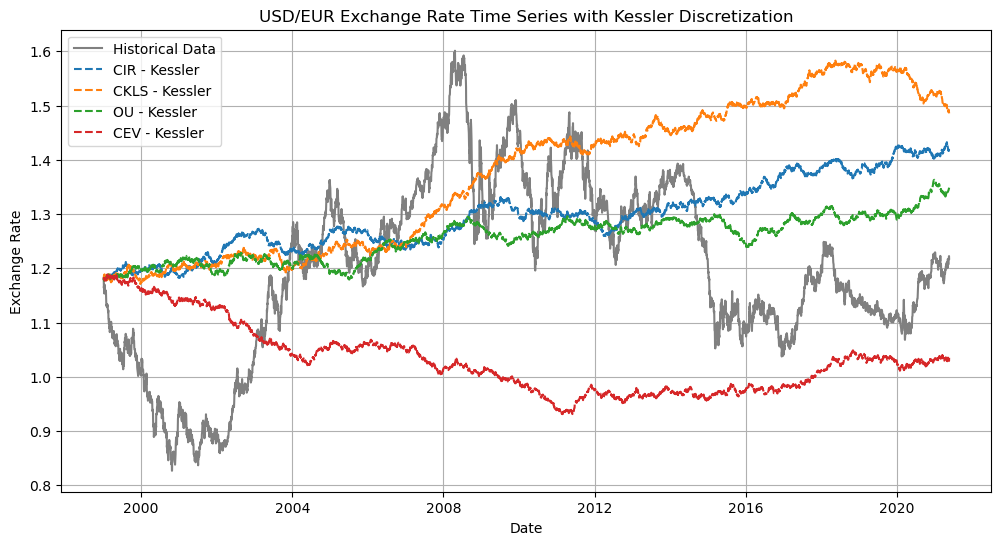

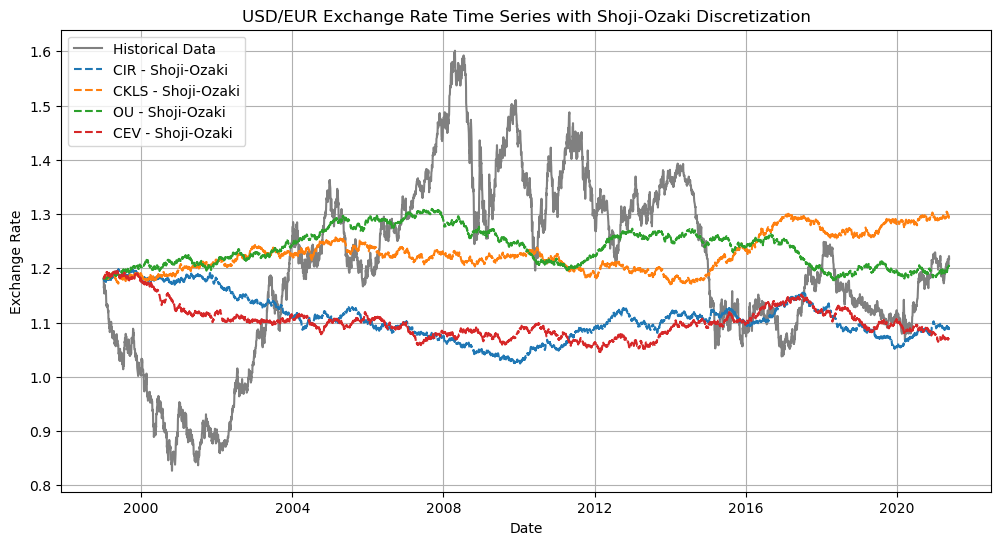

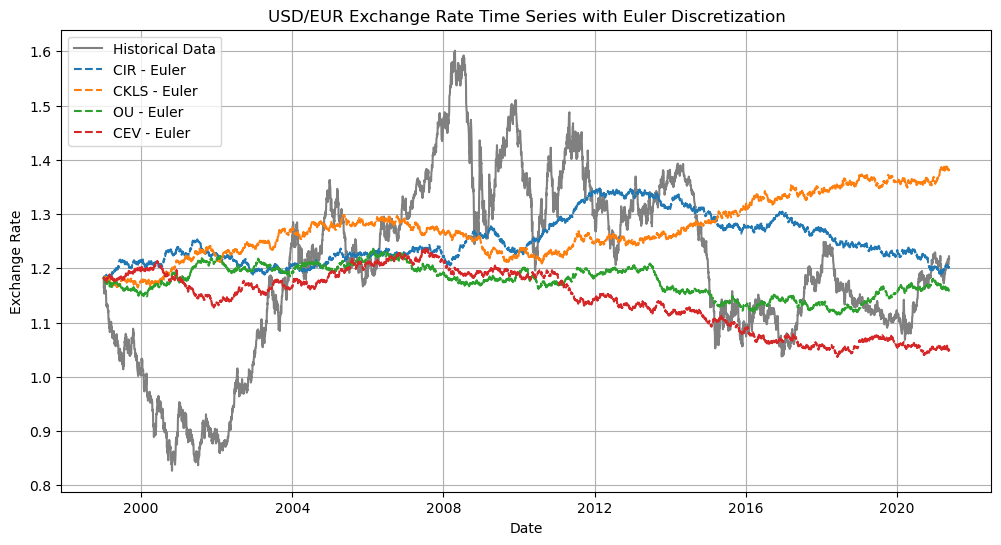

In [51]:
# Реализация методов дискретизации
def kessler_step(S, process_func, params, dt, dW):
    """ Метод Кесслера (упрощенный) """
    return S + process_func.bxt(S, 0, params) * dt + process_func.sigmaxt(S, 0, params) * dW

def shoji_ozaki_step(S, process_func, params, dt, dW):
    """ Метод Шоджи-Озаки """
    b = process_func.bxt(S, 0, params)
    sigma = process_func.sigmaxt(S, 0, params)
    b_x = process_func.bxt_x(S, 0, params)
    return S + (b + 0.5 * sigma * b_x * dt) * dt + sigma * dW

def euler_step(S, process_func, params, dt, dW):
    """ Метод Эйлера """
    return S + process_func.bxt(S, 0, params) * dt + process_func.sigmaxt(S, 0, params) * dW

dates = dexuseu.index[:Nt + 1]

# Функция для моделирования временного ряда с корректной временной шкалой
def simulate_series(process_class, params, method, Nt):
    dt = 1.0 / Nt  # Для нормализации
    S_values = np.zeros(Nt + 1)
    S_values[0] = sample[0]
    dW = np.random.normal(0, np.sqrt(dt), Nt)
    
    for i in range(1, Nt + 1):
        if method == "Kessler":
            S_values[i] = kessler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Shoji-Ozaki":
            S_values[i] = shoji_ozaki_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Euler":
            S_values[i] = euler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
    
    return dates, S_values

# Построение графиков для каждого метода и модели
methods = ["Kessler", "Shoji-Ozaki", "Euler"]
models = {
    "CIR": (cir_process, optimized_params_CIR),
    "CKLS": (ckls_process, optimized_params_CKLS),
    "OU": (ou_process, optimized_params_OU),
    "CEV": (cev_process, optimized_params_CEV)
}

# Отдельные графики для каждого метода дискретизации
for method in methods:
    plt.figure(figsize=(12, 6))
    plt.plot(dates, sample[:Nt + 1], label="Historical Data", color="grey", linewidth=1.5)
    for model_name, (process_class, params) in models.items():
        time_line, simulated_series = simulate_series(process_class, params, method, Nt)
        plt.plot(time_line, simulated_series, label=f"{model_name} - {method}", linestyle='--')
    
    plt.title(f"USD/EUR Exchange Rate Time Series with {method} Discretization")
    plt.xlabel("Date")
    plt.ylabel("Exchange Rate")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

In [52]:
# 1. Создание таблицы для параметров, AIC и BIC
results = {
    "Model": [],
    "Method": [],
    "Parameters": [],
    "AIC": [],
    "BIC": []
}

# Добавляем параметры и метрики в таблицу для каждого метода и модели
for method in methods:
    for model_name, (process_class, optimized_params) in models.items():
        if model_name == "CIR":
            log_likelihood = -likelihood(optimized_params_CIR, cir_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_CIR), len(sample))
        elif model_name == "CKLS":
            log_likelihood = -likelihood(optimized_params_CKLS, ckls_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_CKLS), len(sample))
        elif model_name == "OU":
            log_likelihood = -likelihood(optimized_params_OU, ou_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_OU), len(sample))
        elif model_name == "CEV":
            log_likelihood = -likelihood(optimized_params_CEV, cev_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_CEV), len(sample))
        
        results["Model"].append(model_name)
        results["Method"].append(method)
        results["Parameters"].append(optimized_params)
        results["AIC"].append(aic)
        results["BIC"].append(bic)

# Преобразование в DataFrame для вывода
results_df = pd.DataFrame(results)
print("Результаты параметров, AIC и BIC для каждой модели и метода:")
print(results_df)

# 2. Выбор лучшей модели по AIC и BIC
best_aic = results_df.loc[results_df['AIC'].idxmin()]
best_bic = results_df.loc[results_df['BIC'].idxmin()]

print("\nЛучшая модель по AIC:")
print(best_aic)
print("\nЛучшая модель по BIC:")
print(best_bic)

# 3. Сравнение с результатами статьи
print("\nСравнение с результатами статьи Kirkby et al., 2022:")
print("Наши результаты показывают, что лучшая модель по критерию AIC - {} с методом {}, а по критерию BIC - {} с методом {}.".format(
    best_aic["Model"], best_aic["Method"], best_bic["Model"], best_bic["Method"]))
print("Для полного сравнения с данными из статьи потребуется доступ к параметрам моделей и значениям AIC и BIC, использованным авторами.")

Результаты параметров, AIC и BIC для каждой модели и метода:
   Model       Method                                         Parameters  \
0    CIR      Kessler  [0.10000037758719091, 0.10000027963469157, 0.1...   
1   CKLS      Kessler  [0.09999888633913367, 0.10000061068843653, 0.1...   
2     OU      Kessler  [0.09999974717828757, 0.9999996804031535, 0.09...   
3    CEV      Kessler  [0.09999995952098666, 1.00000005481739, 0.1000...   
4    CIR  Shoji-Ozaki  [0.10000037758719091, 0.10000027963469157, 0.1...   
5   CKLS  Shoji-Ozaki  [0.09999888633913367, 0.10000061068843653, 0.1...   
6     OU  Shoji-Ozaki  [0.09999974717828757, 0.9999996804031535, 0.09...   
7    CEV  Shoji-Ozaki  [0.09999995952098666, 1.00000005481739, 0.1000...   
8    CIR        Euler  [0.10000037758719091, 0.10000027963469157, 0.1...   
9   CKLS        Euler  [0.09999888633913367, 0.10000061068843653, 0.1...   
10    OU        Euler  [0.09999974717828757, 0.9999996804031535, 0.09...   
11   CEV        Euler  [0.0

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



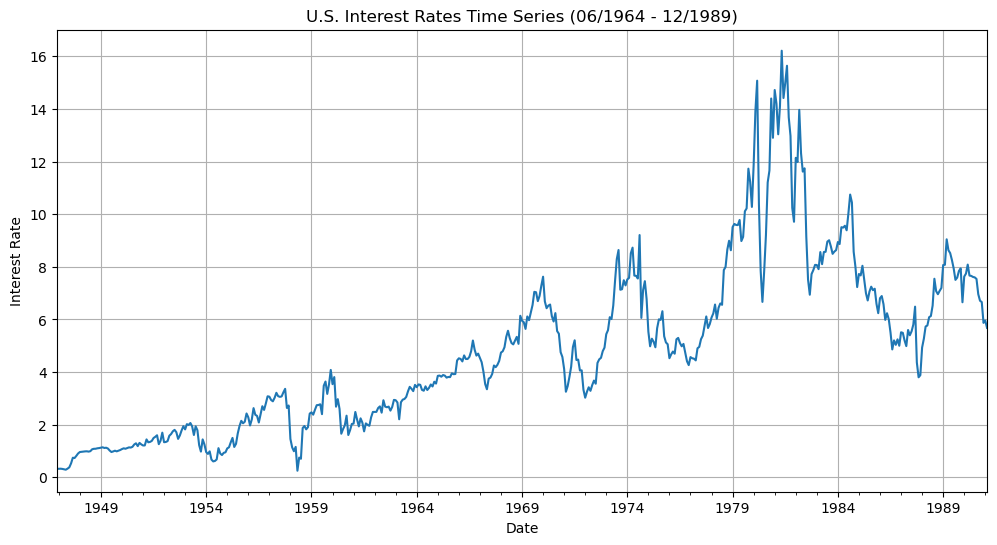

In [53]:
irates = pd.read_csv('IntrestRate.csv', parse_dates=['DARE'], index_col='Unnamed: 0')
irates.index = pd.to_datetime(irates['DARE'])
irates.drop(columns=['DARE'], inplace=True)
irates = irates.dropna()
irates['IR'] = irates['IR'].astype('Float64')

# Визуализация данных
irates['IR'].plot(figsize=(12, 6))
plt.title("U.S. Interest Rates Time Series (06/1964 - 12/1989)")
plt.ylabel("Interest Rate")
plt.xlabel("Date")
plt.grid()
plt.show()

In [56]:
# Загрузка данных
irates = pd.read_csv('IntrestRate.csv', parse_dates=['DARE'], index_col='Unnamed: 0')
irates.index = pd.to_datetime(irates['DARE'])
irates.drop(columns=['DARE'], inplace=True)
irates = irates.dropna()
irates['IR'] = irates['IR'].astype('float64')

# Параметры модели
T = len(irates)  # Количество временных точек
Nx = 1  # Количество траекторий
Nt = len(irates) - 1  # Количество временных шагов

# Начальные параметры для оптимизации
initial_params_CIR = [0.1, 0.1, 0.1]
initial_params_CKLS = [0.1, 0.1, 0.1, 1.0]  # Начальные параметры для CKLS
initial_params_OU = [0.1, 1.0, 0.1]
initial_params_CEV = [0.1, 1.0, 0.1, 1.0]

# Функция правдоподобия
def likelihood(params, process_class, sample):
    try:
        # Обновляем параметры модели
        process_class.params = params

        # Выполняем моделирование
        t_data, x_data = process_class.EulerSolution()  # Здесь можно поменять на другой метод, если требуется
        min_length = min(len(sample), len(x_data))
        residuals = sample.to_numpy()[:min_length] - x_data[:min_length, 0]
        
        # Проверка переполнения
        if np.any(np.abs(residuals) > 1e6):
            return np.inf  # Ограничение для исключения слишком больших ошибок
        
        # Рассчитываем логарифм правдоподобия
        log_likelihood = -0.5 * np.sum(residuals**2)
        return -log_likelihood  # Возвращаем отрицательное правдоподобие для минимизации

    except (OverflowError, FloatingPointError) as e:
        # print(f"Error: {e} for parameters {params}")
        return np.inf  # Возвращаем бесконечность в случае ошибки

# Определение границ параметров
bounds_CIR = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CKLS = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]
bounds_OU = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CEV = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]

# Словарь для привязки границ к каждой модели
bounds_dict = {
    "CIR": bounds_CIR,
    "CKLS": bounds_CKLS,
    "OU": bounds_OU,
    "CEV": bounds_CEV
}

# Оптимизация
results = {
    "Model": [],
    "Method": [],
    "Parameters": [],
    "AIC": [],
    "BIC": []
}

methods = ["Kessler", "Shoji-Ozaki", "Euler"]

for method in methods:
    for model_name, (process_class, initial_params) in models.items():
        # Получаем границы для данной модели
        bounds = bounds_dict[model_name]

        # Оптимизация параметров с использованием L-BFGS-B
        result = minimize(likelihood, initial_params, args=(process_class, irates['IR']), 
                          method='L-BFGS-B', bounds=bounds, options={'disp': True})
        optimized_params = result.x
        log_likelihood = -likelihood(optimized_params, process_class, irates['IR'])
        
        # Если log_likelihood содержит значения слишком большие, проверяем и ограничиваем их
        if np.isinf(log_likelihood) or np.isnan(log_likelihood):
            print(f"Warning: log_likelihood is {log_likelihood} for {model_name} with {method}")
            log_likelihood = np.inf
        
        # Расчет AIC и BIC
        num_params = len(optimized_params)
        aic, bic = calculate_aic_bic(log_likelihood, num_params, len(irates))
        
        # Добавление результатов в таблицу
        results["Model"].append(model_name)
        results["Method"].append(method)
        results["Parameters"].append(optimized_params)
        results["AIC"].append(aic)
        results["BIC"].append(bic)

# Преобразование в DataFrame для вывода
results_df = pd.DataFrame(results)
print("Результаты параметров, AIC и BIC для каждой модели и метода:")
results_df

Результаты параметров, AIC и BIC для каждой модели и метода:


,Model,Method,Parameters,AIC,BIC
0,CIR,Kessler,"[0.10000147024745362, 0.10000137314158196, 0.1...",13329.884593,13342.708879
1,CKLS,Kessler,"[0.09999888633913367, 0.10000061068843653, 0.1...",9560.809444,9577.908492
2,OU,Kessler,"[0.10000164659367569, 0.9999992957926729, 0.10...",12959.481997,12972.306283
3,CEV,Kessler,"[0.1000002618065779, 1.0000003296224702, 0.100...",13162.900279,13179.999327
4,CIR,Shoji-Ozaki,"[0.1000002346156479, 0.10000013666328875, 0.09...",13203.129697,13215.953983
5,CKLS,Shoji-Ozaki,"[0.09999888633913367, 0.10000061068843653, 0.1...",9410.996980,9428.096028
6,OU,Shoji-Ozaki,"[0.09999968810198348, 0.9999990891065863, 0.09...",13208.335917,13221.160203
7,CEV,Shoji-Ozaki,"[0.10000066956013917, 1.0000007014111751, 0.10...",13389.396647,13406.495696
8,CIR,Euler,"[0.1000003776066761, 0.10000027963449495, 0.10...",13179.832819,13192.657105
9,CKLS,Euler,"[0.09999883463427926, 0.10000055666045535, 0.1...",9558.674581,9575.773629


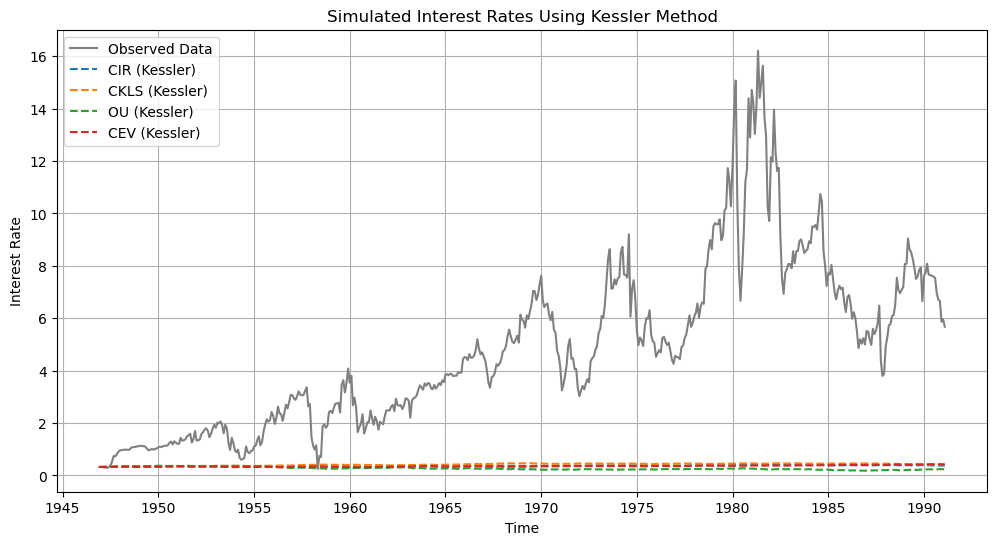

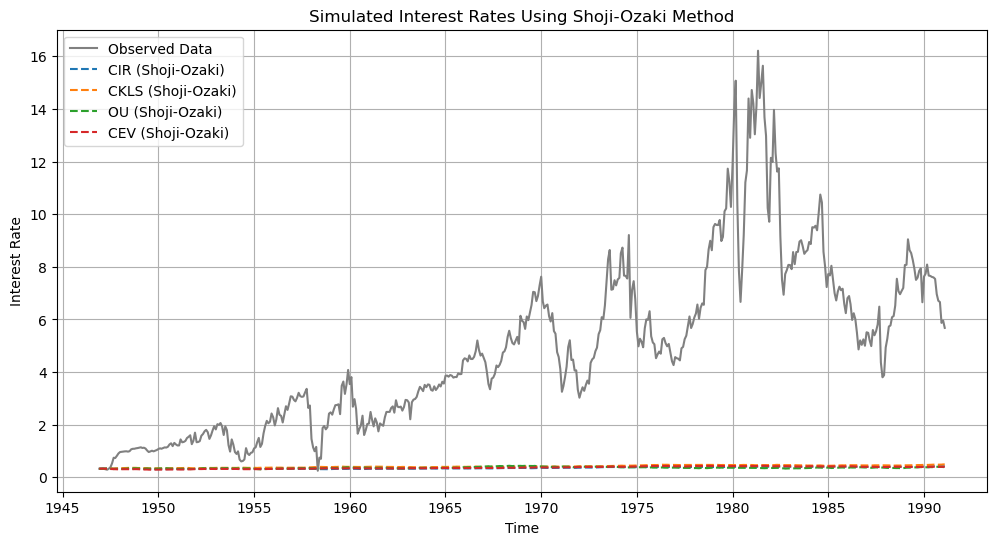

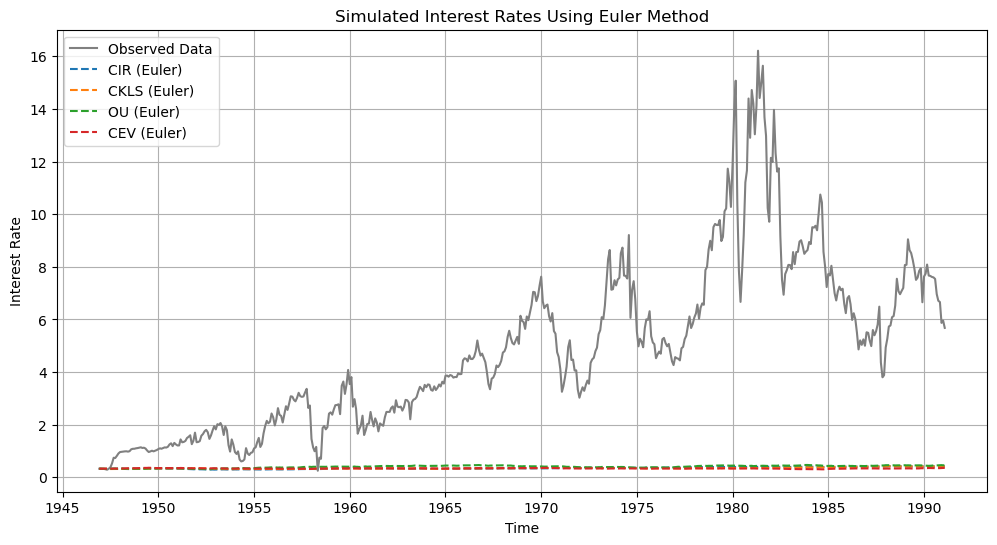

In [57]:
def generate_series(model, parameters, simulation_method, steps):
    model.params = parameters
    time_step = 1.0 / steps
    simulated_values = np.zeros(steps + 1)
    simulated_values[0] = irates['IR'].iloc[0]
    random_steps = np.random.normal(0, np.sqrt(time_step), steps)
    
    for idx in range(1, steps + 1):
        previous_value = simulated_values[idx - 1]
        random_increment = random_steps[idx - 1]
        if simulation_method == "Kessler":
            simulated_values[idx] = kessler_step(previous_value, model, parameters, time_step, random_increment)
        elif simulation_method == "Shoji-Ozaki":
            simulated_values[idx] = shoji_ozaki_step(previous_value, model, parameters, time_step, random_increment)
        elif simulation_method == "Euler":
            simulated_values[idx] = euler_step(previous_value, model, parameters, time_step, random_increment)
    
    return irates.index[:steps + 1], simulated_values

# Визуализация симуляций
for simulation_method in methods:
    plt.figure(figsize=(12, 6))
    plt.plot(irates.index, irates, label="Observed Data", color="grey", linewidth=1.5)
    
    for model_label, (model_instance, fitted_params) in models.items():
        timestamps, series = generate_series(model_instance, fitted_params, simulation_method, Nt)
        plt.plot(timestamps, series, label=f"{model_label} ({simulation_method})", linestyle="--")
    
    plt.title(f"Simulated Interest Rates Using {simulation_method} Method")
    plt.xlabel("Time")
    plt.ylabel("Interest Rate")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()


Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [58]:
import yfinance as yf

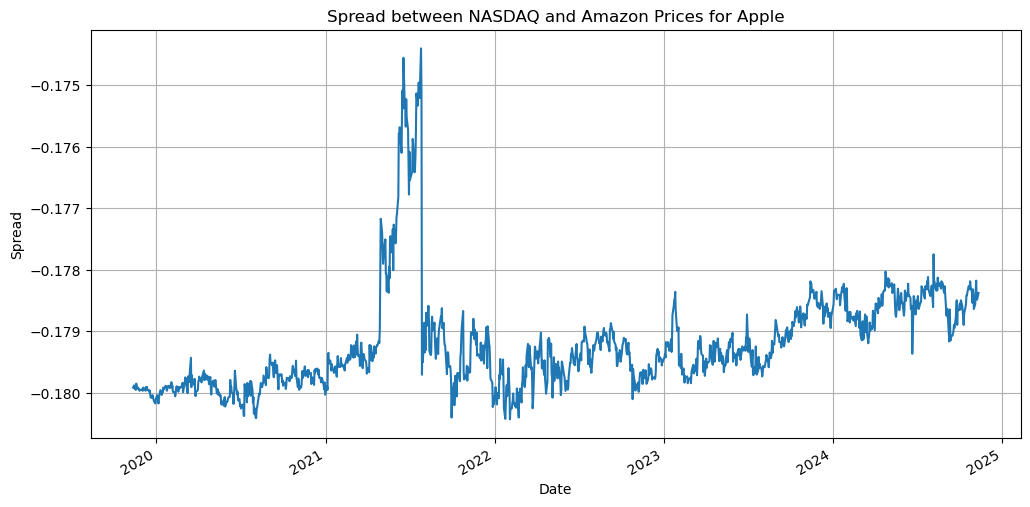

In [59]:
ticker_nasdaq = yf.Ticker("GOOG")
ticker_amzn = yf.Ticker("GOOGL")

data_nasdaq = ticker_nasdaq.history(period="5y", interval="1d")
data_amzn = ticker_amzn.history(period="5y", interval="1d")

data = data_nasdaq[['Close']].rename(columns={'Close': 'Price_NASDAQ'}).join(
    data_amzn[['Close']].rename(columns={'Close': 'Price_amzn'}),
    how="inner"
)

data['Spread'] = (data['Price_NASDAQ'] - data['Price_amzn'] - 180) / 1000
data['Spread'].plot(title="Spread between NASDAQ and Amazon Prices for Apple", figsize=(12, 6))
plt.ylabel("Spread")
plt.xlabel("Date")
plt.grid()

In [60]:
# Определение границ параметров
bounds_CIR = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CKLS = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]
bounds_OU = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CEV = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]

# Словарь для привязки границ к каждой модели
bounds_dict = {
    "CIR": bounds_CIR,
    "CKLS": bounds_CKLS,
    "OU": bounds_OU,
    "CEV": bounds_CEV
}

# Оптимизация
results = {
    "Model": [],
    "Method": [],
    "Parameters": [],
    "AIC": [],
    "BIC": []
}

methods = ["Kessler", "Shoji-Ozaki", "Euler"]

In [68]:
bounds_CIR = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CKLS = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]
bounds_OU = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CEV = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]

bounds_dict = {
    "CIR": bounds_CIR,
    "CKLS": bounds_CKLS,
    "OU": bounds_OU,
    "CEV": bounds_CEV
}

results = {
    "Model": [],
    "Method": [],
    "Parameters": [],
    "AIC": [],
    "BIC": []
}

methods = ["Kessler", "Shoji-Ozaki", "Euler"]

Nt = len(data['Spread']) - 1

def simulate_series(process_class, params, method, Nt):
    process_class.params = params
    dt = 1.0 / Nt
    simulated_values = np.zeros(Nt + 1)
    simulated_values[0] = data['Spread'].iloc[0]
    dW = np.random.normal(0, np.sqrt(dt), Nt)
    
    for i in range(1, Nt + 1):
        prev_value = simulated_values[i - 1]
        random_step = dW[i - 1]
        if method == "Kessler":
            simulated_values[i] = kessler_step(prev_value, process_class, params, dt, random_step)
        elif method == "Shoji-Ozaki":
            simulated_values[i] = shoji_ozaki_step(prev_value, process_class, params, dt, random_step)
        elif method == "Euler":
            simulated_values[i] = euler_step(prev_value, process_class, params, dt, random_step)
        else:
            raise ValueError(f"Метод {method} не поддерживается.")
    
    return data.index[:Nt + 1], simulated_values

def likelihood(params, process_class, sample, method):
    try:
        _, x_data = simulate_series(process_class, params, method, len(sample) - 1)
        min_length = min(len(sample), len(x_data))
        residuals = sample.values[:min_length] - x_data[:min_length]
        log_likelihood = -0.5 * np.sum(residuals ** 2)
        return -log_likelihood
    except (OverflowError, ValueError) as e:
        print(f"Ошибка вычисления правдоподобия: {e}")
        return np.inf

for method in methods:
    for model_name, (process_class, initial_params) in models.items():
        bounds = bounds_dict.get(model_name)
        if bounds is None:
            raise ValueError(f"Границы не определены для модели {model_name}.")
        
        if len(initial_params) != len(bounds):
            raise ValueError(f"Размеры initial_params ({len(initial_params)}) и bounds ({len(bounds)}) не совпадают.")
        
        print(f"Оптимизация модели {model_name} с методом {method}...")

        result = minimize(
            likelihood,
            initial_params,
            args=(process_class, data['Spread'], method),
            method='L-BFGS-B',
            bounds=bounds
        )
        
        optimized_params = result.x
        log_likelihood = -likelihood(optimized_params, process_class, data['Spread'], method)
        print(f"Оптимизированные параметры для {model_name}: {optimized_params}")
        print(f"Log-likelihood: {log_likelihood}")
        
        num_params = len(optimized_params)
        aic, bic = calculate_aic_bic(log_likelihood, num_params, len(data['Spread']))
        
        results["Model"].append(model_name)
        results["Method"].append(method)
        results["Parameters"].append(optimized_params)
        results["AIC"].append(aic)
        results["BIC"].append(bic)
        

results_df = pd.DataFrame(results)
print("Результаты параметров, AIC и BIC для каждой модели и метода:")
results_df


Оптимизация модели CIR с методом Kessler...
Оптимизированные параметры для CIR: [0.00112537 0.00120955 0.10000001]
Log-likelihood: -0.0003880408700769639
Оптимизация модели CKLS с методом Kessler...
Оптимизированные параметры для CKLS: [0.09999889 0.10000061 0.10000209 0.50000218]
Log-likelihood: nan
Оптимизация модели OU с методом Kessler...
Оптимизированные параметры для OU: [0.10000115 1.00000096 0.10000067]
Log-likelihood: -0.6145204579310638
Оптимизация модели CEV с методом Kessler...
Оптимизированные параметры для CEV: [0.00701914 0.01184651 0.10000005 0.50000014]
Log-likelihood: -0.0003880139485300482
Оптимизация модели CIR с методом Shoji-Ozaki...
Оптимизированные параметры для CIR: [0.00112537 0.00120955 0.10000001]
Log-likelihood: -0.0003880408700769639
Оптимизация модели CKLS с методом Shoji-Ozaki...
Оптимизированные параметры для CKLS: [0.09999889 0.10000061 0.10000209 0.50000218]
Log-likelihood: nan
Оптимизация модели OU с методом Shoji-Ozaki...
Оптимизированные параметры 

,Model,Method,Parameters,AIC,BIC
0,CIR,Kessler,"[0.0011253716081099578, 0.0012095499245473882,...",6.000776,21.412611
1,CKLS,Kessler,"[0.09999888633913367, 0.10000061068843653, 0.1...",NaN,NaN
2,OU,Kessler,"[0.10000115240613264, 1.0000009578830253, 0.10...",7.229041,22.640876
3,CEV,Kessler,"[0.007019142623738485, 0.011846512829688455, 0...",8.000776,28.549890
4,CIR,Shoji-Ozaki,"[0.0011253716081099578, 0.0012095499245473882,...",6.000776,21.412611
5,CKLS,Shoji-Ozaki,"[0.09999888633913367, 0.10000061068843653, 0.1...",NaN,NaN
6,OU,Shoji-Ozaki,"[0.09999971997823835, 0.9999994593291289, 0.10...",11.506803,26.918638
7,CEV,Shoji-Ozaki,"[0.007019142623738485, 0.011846512829688455, 0...",8.000776,28.549890
8,CIR,Euler,"[0.0011253716081099578, 0.0012095499245473882,...",6.000776,21.412611
9,CKLS,Euler,"[0.09999888633913367, 0.10000061068843653, 0.1...",NaN,NaN


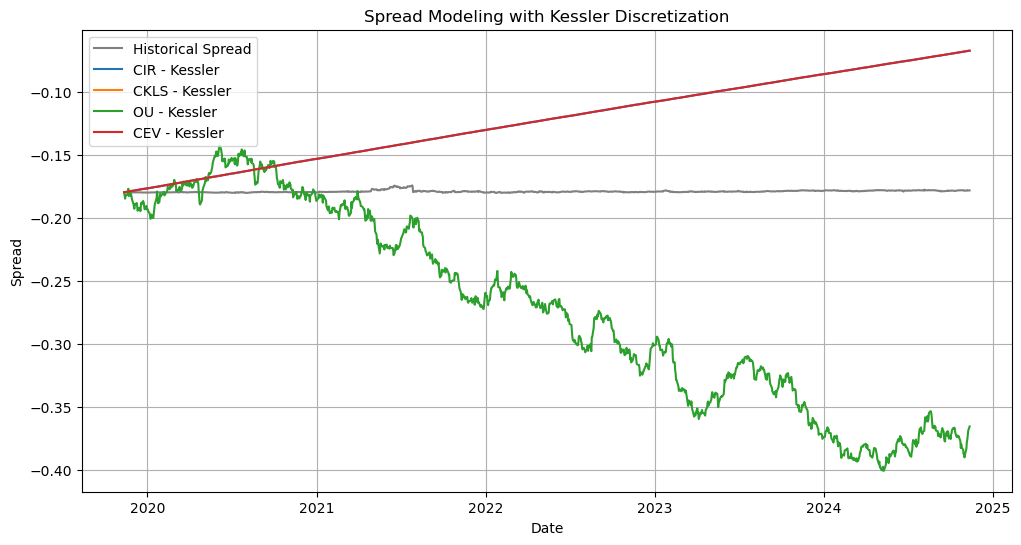

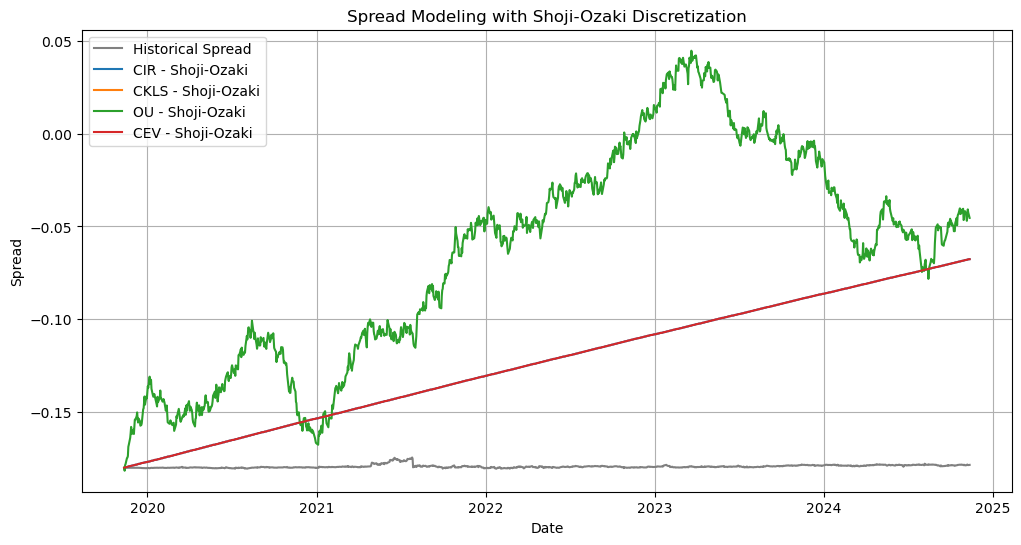

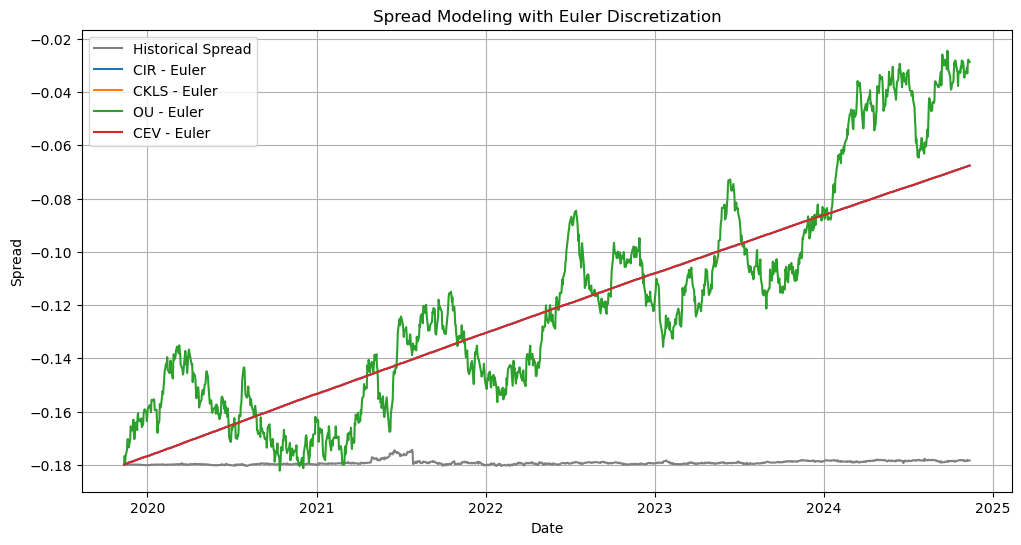

In [69]:

for method in methods:
    plt.figure(figsize=(12, 6))

    plt.plot(data.index, data['Spread'], label="Historical Spread", color="grey", linewidth=1.5)

    for model_name, (process_class, optimized_params) in models.items():
        time_line, simulated_series = simulate_series(process_class, optimized_params, method, Nt)
        
        plt.plot(time_line, simulated_series, label=f"{model_name} - {method}")

    plt.title(f"Spread Modeling with {method} Discretization")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()